# Working with Grids

Grids are the foundation of iso-surface extraction. They define **where** in 3D space we sample scalar values, and **store** those values for the extraction algorithms.

`isoext` provides two grid types:
- **UniformGrid** — Dense regular lattice, simple and fast
- **SparseGrid** — Only stores active cells, memory-efficient for large sparse domains


In [1]:
import torch
import isoext
from _viz import show_mesh


## UniformGrid

A `UniformGrid` divides a 3D bounding box into a regular lattice of cells.

### Creating a Grid

```python
UniformGrid(shape, aabb_min=[-1,-1,-1], aabb_max=[1,1,1])
```

- `shape`: Number of cells in each dimension `[nx, ny, nz]`
- `aabb_min` / `aabb_max`: Axis-aligned bounding box corners


In [2]:
# Create a 64³ grid spanning [-1, 1]³ (default bounds)
grid = isoext.UniformGrid([64, 64, 64])

print(f"Cells: {grid.get_num_cells():,}")
print(f"Points: {grid.get_num_points():,}")


Cells: 250,047
Points: 262,144


### Getting Point Positions

`get_points()` returns the 3D coordinates of all grid points as a PyTorch tensor. This is essential for computing your scalar field values.


In [3]:
points = grid.get_points()

print(f"Shape: {points.shape}")  # (nx, ny, nz, 3)
print(f"Device: {points.device}")
print(f"Dtype: {points.dtype}")

# Points range from aabb_min to aabb_max
print(f"\nMin corner: {points[0, 0, 0]}")
print(f"Max corner: {points[-1, -1, -1]}")


Shape: torch.Size([64, 64, 64, 3])
Device: cuda:0
Dtype: torch.float32

Min corner: tensor([-1., -1., -1.], device='cuda:0')
Max corner: tensor([1., 1., 1.], device='cuda:0')


### Setting Values

`set_values()` stores your scalar field on the grid. The values can come from **anywhere** — you're not limited to the built-in SDF utilities.

The iso-surface is extracted where values equal zero:
- **Negative** values → inside the surface
- **Positive** values → outside the surface


Sphere: 9,168 vertices


2025-12-30 01:16:08.799 (   0.585s) [    78D204087740]vtkXOpenGLRenderWindow.:1458  WARN| bad X server connection. DISPLAY=


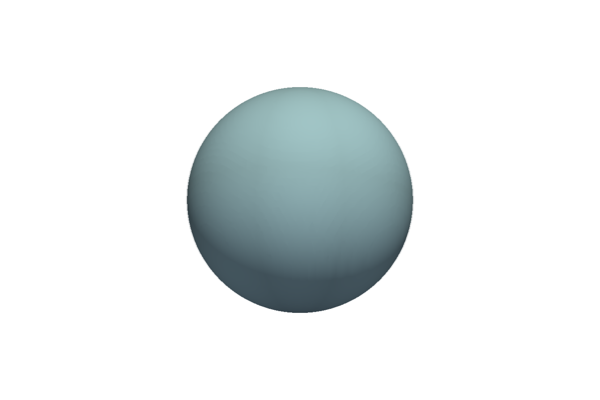

In [4]:
# Example 1: Simple sphere using raw PyTorch
# No SDF classes needed — just compute distance from origin minus radius
points = grid.get_points()
radius = 0.7
values = points.norm(dim=-1) - radius  # Signed distance to sphere

grid.set_values(values)
v, f = isoext.marching_cubes(grid)
print(f"Sphere: {v.shape[0]:,} vertices")
show_mesh(v, f)


Gyroid: 38,760 vertices


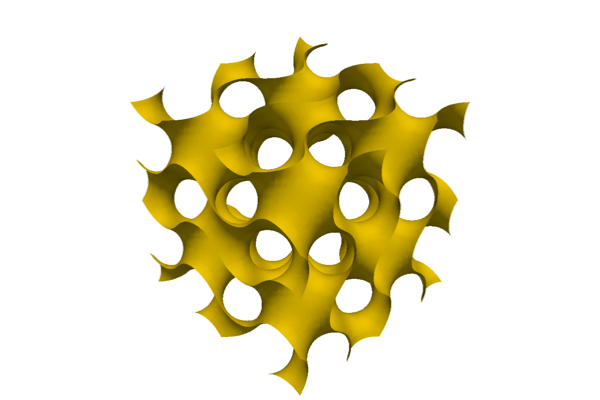

In [5]:
# Example 2: Gyroid — a triply periodic minimal surface
points = grid.get_points()
x, y, z = points[..., 0], points[..., 1], points[..., 2]
scale = 6.0

gyroid = (
    torch.sin(scale * x) * torch.cos(scale * y) +
    torch.sin(scale * y) * torch.cos(scale * z) +
    torch.sin(scale * z) * torch.cos(scale * x)
)

grid.set_values(gyroid)
v, f = isoext.marching_cubes(grid)
print(f"Gyroid: {v.shape[0]:,} vertices")
show_mesh(v, f, color="gold")


### Using Neural Networks

Since `get_points()` returns a standard PyTorch tensor on CUDA, you can feed it directly to a neural network:


In [6]:
# Pseudocode for neural SDF extraction:
#
# grid = isoext.UniformGrid([128, 128, 128])
# points = grid.get_points()  # (128, 128, 128, 3)
#
# # Reshape for batch processing
# points_flat = points.reshape(-1, 3)  # (N, 3)
#
# # Query your neural network
# with torch.no_grad():
#     values_flat = model(points_flat)  # (N, 1) or (N,)
#
# # Reshape back and set on grid
# values = values_flat.reshape(points.shape[:-1])
# grid.set_values(values)
#
# vertices, faces = isoext.marching_cubes(grid)


## SparseGrid

For large domains where the surface occupies only a small region, `SparseGrid` saves memory by only storing active cells.

This is useful for:
- High-resolution extraction in large scenes
- Adaptive refinement workflows
- Memory-constrained applications


In [7]:
# Create a sparse grid with the same logical resolution
sparse_grid = isoext.SparseGrid([64, 64, 64])

print(f"Initially: {sparse_grid.get_num_cells()} active cells")

# Add cells near the surface we want to extract
# Cell indices are linearized: idx = x + y*nx + z*nx*ny
cell_indices = torch.arange(0, 1000, device="cuda", dtype=torch.int32)
sparse_grid.add_cells(cell_indices)

print(f"After adding: {sparse_grid.get_num_cells()} active cells")


Initially: 0 active cells
After adding: 1000 active cells


### SparseGrid Workflow

With `SparseGrid`, you work with cells explicitly:

1. **Add cells** where you expect the surface
2. **Get points** for those cells
3. **Compute and set values**
4. **Optionally filter** to cells that actually cross the surface
5. **Extract** the mesh


Processing 10738 chunks
Active cells: 2416778
Extracted: 2,416,776 vertices


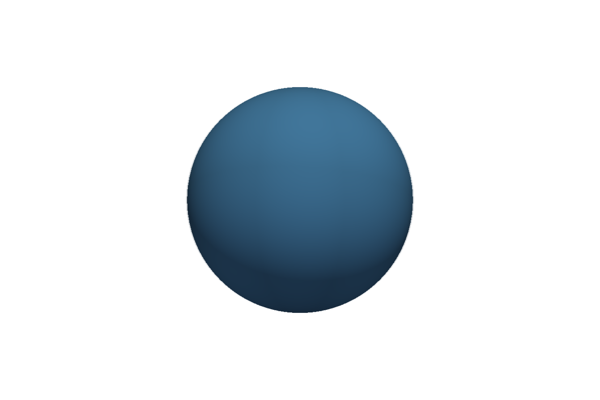

In [8]:
# Complete SparseGrid example
sparse_grid = isoext.SparseGrid([1024, 1024, 1024])

# For this demo, we'll use get_potential_cell_indices to get all possible cells in chunks
# In practice, you'd use spatial hashing or other methods to find relevant cells
# If you know the active indices, just set them using sparse_grid.add_cells(active)
chunks = sparse_grid.get_potential_cell_indices(100000)
print(f"Processing {len(chunks)} chunks")

for chunk in chunks:
    # Get corner positions for these cells
    points = sparse_grid.get_points_by_cell_indices(chunk)  # (N, 8, 3)
    
    # Compute values at corners (sphere SDF)
    values = points.norm(dim=-1) - 0.7  # (N, 8)
    
    # Filter to cells that cross the surface (have both + and - values)
    active = sparse_grid.filter_cell_indices(chunk, values, level=0.0)
    
    if active is not None and active.numel() > 0:
        sparse_grid.add_cells(active)

print(f"Active cells: {sparse_grid.get_num_cells()}")

# Recompute values for the cells we're keeping
points = sparse_grid.get_points()
values = points.norm(dim=-1) - 0.7
# Note: set_values expects (num_cells, 8) tensor
# We set values for all currently active cells
sparse_grid.set_values(values)

v, f = isoext.marching_cubes(sparse_grid)
print(f"Extracted: {v.shape[0]:,} vertices")
show_mesh(v, f, color="steelblue")


## Summary

**Key points:**
- Use `get_points()` to get coordinates for computing your scalar field
- Values can come from anywhere: math formulas, SDFs, neural networks, simulations
- Negative values = inside, positive = outside, zero = surface
- Use `UniformGrid` for most cases, `SparseGrid` for large sparse domains

**Next:** [Marching Cubes](marching_cubes.ipynb) or [Dual Contouring](dual_contouring.ipynb)
